In [ ]:
import os
import zipfile
from google.colab import drive

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# 2. 압축 파일 경로 설정
zip_path = '/content/drive/MyDrive/2nd_test.zip'

# 3. 압축 풀 경로 설정 (Colab 내부 저장소)
extract_path = '/content/dataset'

# 4. 압축 풀기
print("압축 해제 중")

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("압축 해제 완료!")
except FileNotFoundError:
    print(f"오류: {zip_path} 파일을 찾을 수 없습니다. 구글 드라이브에 파일이 있는지 확인해 주세요.")

# 5. 파일 확인
# 압축이 잘 풀렸는지 파일 몇 개만 찍어보기.
# 보통 '2nd_test' 폴더 안에 데이터가 들어있을 확률이 높음.
for root, dirs, files in os.walk(extract_path):
    print(f"폴더: {root}")
    print(f"파일 개수: {len(files)}")
    if len(files) > 0:
        print(f"예시 파일: {files[:5]}")
    print("-" * 20)
    break # 최상위만 확인하고 종료

Mounted at /content/drive
압축 해제 중입니다... (데이터가 많아서 1~2분 정도 걸릴 수 있습니다)
압축 해제 완료!
폴더: /content/dataset
파일 개수: 0
--------------------


In [ ]:
# 실제 데이터가 들어있는 폴더 찾기
# (압축 풀린 곳 안에 '2nd_test'라는 폴더가 있는지 확인)
data_dir = '/content/dataset/2nd_test'

if not os.path.exists(data_dir):
    # 만약 2nd_test 폴더 없이 바로 파일들이 풀린경우 대비
    data_dir = '/content/dataset'

print(f"최종 데이터 경로: {data_dir}")

import pandas as pd
import numpy as np

filenames = sorted([f for f in os.listdir(data_dir) if not f.startswith('.')])
print(f"불러올 파일 개수: {len(filenames)}개") # 984개가 나와야 정상

# --- 2단계: RMS 변환 및 데이터프레임 생성 ---
raw_data = []

print(f"데이터 전처리 시작... ({len(filenames)}개 파일 처리 중)")

# 984개 파일을 순회하며 RMS 계산
for filename in filenames:
    # 1. 파일 읽기 (탭으로 구분된 데이터)
    filepath = os.path.join(data_dir, filename)
    df = pd.read_csv(filepath, sep='\t', header=None)

    # 2. RMS 계산 (Root Mean Square: 진동의 크기 요약)
    # 데이터는 4개의 컬럼(Bearing 1~4)으로 구성됨
    rms_values = np.sqrt((df**2).mean())
    raw_data.append(rms_values)

# 3. DataFrame으로 변환
df_rms = pd.DataFrame(raw_data)
df_rms.columns = ['Bearing1', 'Bearing2', 'Bearing3', 'Bearing4']
# 파일명을 시간 인덱스로 변환 (시각화를 위해)
df_rms.index = pd.to_datetime(filenames, format='%Y.%m.%d.%H.%M.%S')

print("✅ 전처리 완료!")
print(f"데이터 크기: {df_rms.shape}")  # (984, 4)가 나와야 함
print(df_rms.head()) # 데이터 눈으로 확인

최종 데이터 경로: /content/dataset/2nd_test
불러올 파일 개수: 984개
데이터 전처리 시작... (984개 파일 처리 중)
✅ 전처리 완료!
데이터 크기: (984, 4)
                     Bearing1  Bearing2  Bearing3  Bearing4
2004-02-12 10:32:39  0.074179  0.090944  0.109404  0.054103
2004-02-12 10:42:39  0.075382  0.093419  0.109817  0.056101
2004-02-12 10:52:39  0.076230  0.093718  0.109861  0.056145
2004-02-12 11:02:39  0.078724  0.092947  0.110667  0.056807
2004-02-12 11:12:39  0.078474  0.095348  0.107506  0.056841


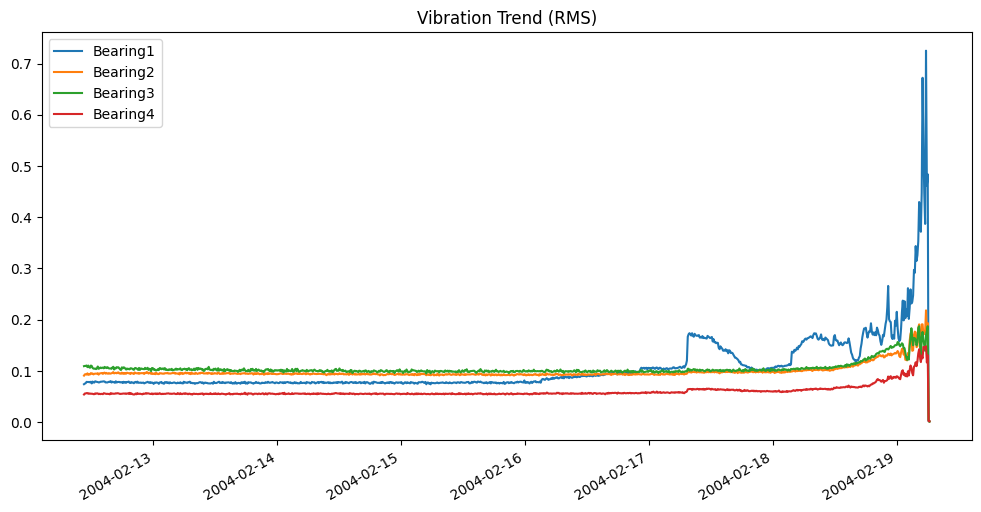

학습 데이터 형태: torch.Size([390, 10, 4])


In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# --- 3단계: 데이터 시각화 및 분할 ---

# 1. 전체 데이터 추세 확인 (Bearing 1이 나중에 고장남)
df_rms.plot(figsize=(12, 6), title="Vibration Trend (RMS)")
plt.show()

# 2. 정규화 (0~1 사이로 변환) - LSTM 학습을 위해 필수
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_rms.values)

# 3. 학습/테스트 분할
# 정상 구간(초반 400개)만 학습에 사용
train_data = scaled_data[:400]
test_data = scaled_data # 전체 데이터를 테스트로 사용하여 이상 발생 시점 포착

# 4. Sliding Window 데이터 생성 함수
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
    return np.array(xs)

# 시퀀스 길이 설정 (과거 10개의 데이터를 보고 패턴 학습)
SEQ_LENGTH = 10

X_train = create_sequences(train_data, SEQ_LENGTH)
X_test = create_sequences(test_data, SEQ_LENGTH)

# PyTorch Tensor로 변환
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

print(f"학습 데이터 형태: {X_train_tensor.shape}") # (390, 10, 4)

In [ ]:
import torch.nn as nn

# --- 4단계: 모델 정의 및 학습 ---

# GPU 사용 가능 여부 확인 (Colab에서는 GPU 켜는 게 빠름)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 장치: {device}")

class AnomalyDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(AnomalyDetector, self).__init__()
        self.seq_len = seq_len

        # Encoder: 입력(4개 센서값) -> 압축
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # Decoder: 압축 정보 -> 원래대로 복원
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        # 인코딩
        _, (hidden, _) = self.encoder(x)

        # 디코딩을 위한 차원 맞추기
        input_repeat = hidden.squeeze(0).unsqueeze(1).repeat(1, self.seq_len, 1)

        # 디코딩
        output, _ = self.decoder(input_repeat)
        prediction = self.output_layer(output)
        return prediction

# 모델 생성
model = AnomalyDetector(input_dim=4, hidden_dim=32, seq_len=SEQ_LENGTH).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 학습 데이터 로더
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

# 학습 루프
print("학습 시작...")
model.train()
for epoch in range(100): # 100번 반복 학습
    for batch in train_loader:
        inputs = batch[0].to(device) # 데이터를 GPU로 이동

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs) # 복원 오차 계산
        loss.backward()
        optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

print("✅ 학습 완료!")

사용 중인 장치: cpu
학습 시작...
Epoch 20, Loss: 0.000075
Epoch 40, Loss: 0.000076
Epoch 60, Loss: 0.000068
Epoch 80, Loss: 0.000055
Epoch 100, Loss: 0.000097
✅ 학습 완료!


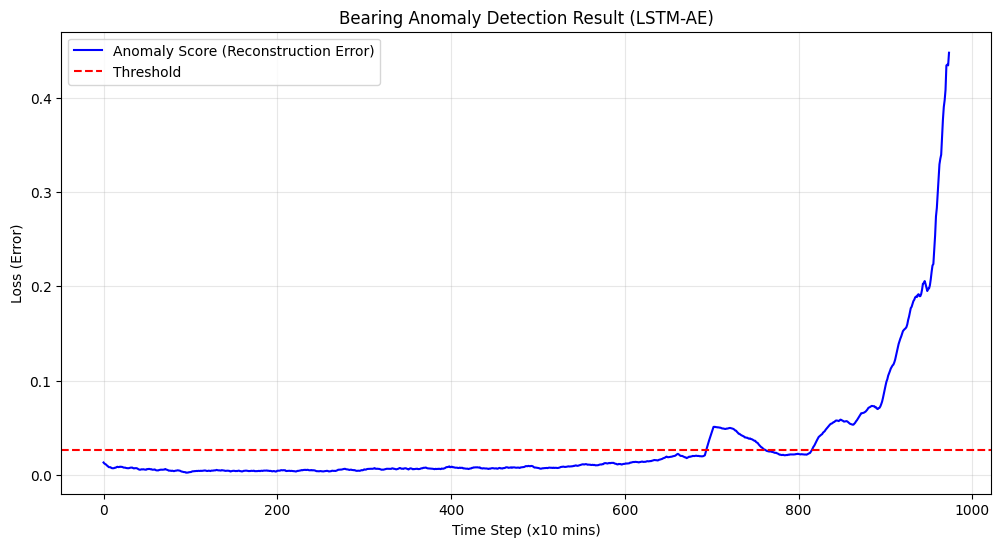

In [ ]:
# --- 5단계: 이상 탐지 및 시각화 ---

model.eval()
with torch.no_grad():
    # 테스트 데이터(전체)를 모델에 넣음
    X_test_tensor = X_test_tensor.to(device)
    pred = model(X_test_tensor)

    # 복원 오차(Loss) 계산: |예측값 - 실제값|
    loss_per_point = torch.mean(torch.abs(pred - X_test_tensor), dim=2)
    # 시퀀스별 평균 Loss (Anomaly Score)
    anomaly_scores = torch.mean(loss_per_point, dim=1).cpu().numpy()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(anomaly_scores, label='Anomaly Score (Reconstruction Error)', color='blue')

# 임계치 설정 (학습 구간 최대 에러의 2배 정도로 설정해보기)
# 빨간 점선 위로 그래프가 튀어 오르면 '이상'으로 간주
threshold = np.max(anomaly_scores[:400]) * 2.0
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.title("Bearing Anomaly Detection Result (LSTM-AE)")
plt.xlabel("Time Step (x10 mins)")
plt.ylabel("Loss (Error)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

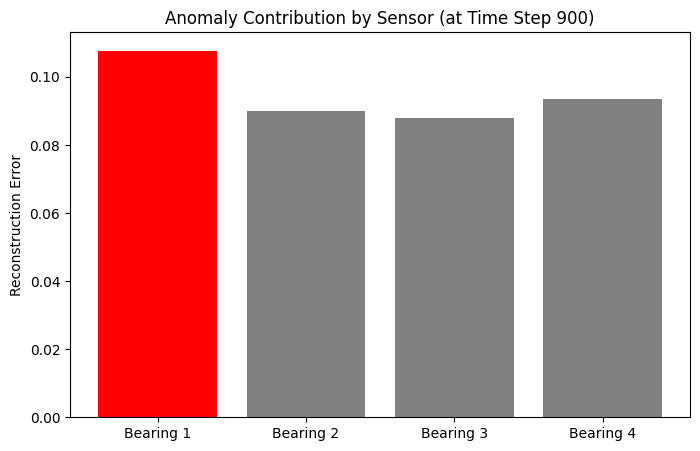

In [ ]:
# [Upgrade] 베어링별 기여도 분석 (Contribution Analysis)
# 모델이 내놓은 예측값(pred)과 실제값(X_test_tensor)의 차이를 베어링별로 뜯어봅니다.

# (Step 800 이후, 즉 고장이 확실한 구간의 데이터를 가져옵니다)
fault_idx = 900
input_sample = X_test_tensor[fault_idx].unsqueeze(0).to(device)
with torch.no_grad():
    recon_sample = model(input_sample)

# 베어링별 오차 계산 (Feature 차원인 dim=2는 유지하고, 시간 차원 dim=1만 평균)
# input_sample shape: (1, 10, 4) -> (Batch, Time, Features)
loss_per_sensor = torch.mean(torch.abs(recon_sample - input_sample), dim=1).cpu().numpy()[0]

# 시각화
sensors = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
plt.figure(figsize=(8, 5))
plt.bar(sensors, loss_per_sensor, color=['red', 'gray', 'gray', 'gray'])
plt.title(f"Anomaly Contribution by Sensor (at Time Step {fault_idx})")
plt.ylabel("Reconstruction Error")
plt.show()